# А/Б-тестирование

### Описание задачи

Задача – провести оценку результатов А/Б-тестирования.

### Техническое задание

- Название теста: `recommender_system_test`;
- группы: А — контрольная, B — новая платёжная воронка;
- дата запуска: 2020-12-07;
- дата остановки набора новых пользователей: 2020-12-21;
- дата остановки: 2021-01-04;
- аудитория: 15% новых пользователей из региона EU;
- назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;
- ожидаемое количество участников теста: 6000.
- ожидаемый эффект: за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%:
    - конверсии в просмотр карточек товаров — событие `product_page`,
    - просмотры корзины — `product_cart`,
    - покупки — `purchase`.

### Описание данных

`ab_project_marketing_events.csv` — календарь маркетинговых событий на 2020 год.

Структура файла:

- `name` — название маркетингового события;
- `regions` — регионы, в которых будет проводиться рекламная кампания;
- `start_dt` — дата начала кампании;
- `finish_dt` — дата завершения кампании.

---

`final_ab_new_users.csv` — пользователи, зарегистрировавшиеся с 7 по 21 декабря 2020 года.

Структура файла:

- `user_id` — идентификатор пользователя;
- `first_date` — дата регистрации;
- `region` — регион пользователя;
- `device` — устройство, с которого происходила регистрация.

----

`final_ab_events.csv` — действия новых пользователей в период с 7 декабря 2020 по 4 января 2021 года.

Структура файла:

- `user_id` — идентификатор пользователя;
- `event_dt` — дата и время покупки;
- `event_name` — тип события;
- `details` — дополнительные данные о событии. Например, для покупок, `purchase,` в этом поле хранится стоимость покупки в долларах.

----

`final_ab_participants.csv` — таблица участников тестов.

Структура файла:

- `user_id` — идентификатор пользователя;
- `ab_test` — название теста;
- `group` — группа пользователя.

### План исследования

1. Подключение библиотек и выгрузка данных,
2. Исследование сырых данных,
3. Предобработка данных,
4. Оценка корректности проведения теста,
5. Исследовательский анализ данных,
6. Оценка результатов А/Б-тестирования
7. Общие выводы.

# Полкдючение библиотек и выгрузка данных

Подключим необходимые библиотеки:

In [2]:
# импорт библиотек
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import statsmodels.stats.api as sms
import plotly.io as pio
import warnings

from plotly.subplots import make_subplots
from tqdm import tqdm
from statsmodels.stats.proportion import proportions_ztest

warnings.filterwarnings('ignore')
pio.renderers.default='jpeg'

In [3]:
# функция для настройки стиля графиков
def style_plot(
    fig,
    xlabel='',
    ylabel='',
    title='',
    yticks=True  
):
    
    fig.update_layout(
        autosize=True,
        xaxis_title_text=xlabel,
        yaxis_title_text=ylabel,
        title_font_size=24,
        plot_bgcolor='white',
        xaxis=dict(
            showline=True,
            linecolor='#58595B',
            color='black',
            # categoryorder='total descending'
        ),
        yaxis=dict(
            color='black',
            showgrid=True,
            gridcolor='#E6E7E8',
            showticklabels=yticks
        ),
        title=dict(
            text=title,
            font=dict(
                color='black'
            )
        )
    )

In [4]:
# функция для настройки стиля нескольких графиков
def style_subplots(
    fig,
    title='',
    showlegend=False
    ):
    

    fig.update_layout(
        title_text=title,
        width=800,
        showlegend=showlegend,
        plot_bgcolor='white',
        bargap=0.1,
        title_font_color='black',
        title_font_size=24, # размер шрифта заголовка
    )

    fig.update_xaxes(
        showline=True,
        linecolor='#58595B',
    )

    fig.update_yaxes(
        gridcolor='#E6E7E8',
    )

    return fig

In [5]:
# основная палитра цветов
colors = ['#' + i for i in ["264653","2a9d8f","e9c46a","f4a261","e76f51"]]

# задаем прозрачность для цветов
def opacity_colors(opacity):
    colors_rgba = ['rgba(38, 70, 83, ', 'rgba(42, 157, 143, ', 'rgba(233, 196, 106, ',
                   'rgba(244, 162, 97, ', 'rgba(231, 111, 81, ']

    colors_opacity = [i + str(opacity) + ')' for i in colors_rgba]

    return colors_opacity

Выгрузим данные:

In [6]:
# локальная выгрузка
try:
    marketing = pd.read_csv('datasets/ab_project_marketing_events.csv')
    events = pd.read_csv('datasets/final_ab_events.csv')
    new_users = pd.read_csv('datasets/final_ab_new_users.csv')
    participants = pd.read_csv('datasets/final_ab_participants.csv')
# выгрузка с сервера
except:
    marketing = pd.read_csv('/datasets/ab_project_marketing_events.csv')
    events = pd.read_csv('/datasets/final_ab_events.csv')
    new_users = pd.read_csv('/datasets/final_ab_new_users.csv')
    participants = pd.read_csv('/datasets/final_ab_participants.csv')

Данные и библиотеки загружены, можно приступить к их изучению.

# Исследование сырых данных

Цель данного этапа сделать первый взгляд на данные и понять какие моменты нужно исправить при предобработке данных. Будем действовать по порядку по каждому датасету. Сначала будем смотреть на первые 5 строк, затем на общую информацию, а потом на описательные статистики. На основе просмотренного будем ставить задачи на предобработку.

### Таблица маркетинговых активностей

In [7]:
# выводим первые 5 строк датасета
marketing.head()

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11


In [8]:
# общая информация по датасету
marketing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes


In [9]:
# описательная статистика
marketing.describe()

,name,regions,start_dt,finish_dt
count,14,14,14,14
unique,14,6,14,14
top,Christmas&New Year Promo,APAC,2020-12-25,2021-01-03
freq,1,4,1,1


Что можно исправить в этом датасете:
* перевести даты в формат правильный формат,
* можно заменить столбец `regions` на столбцы с регионами, с булевыми значениями.

### Таблица новых пользователей

In [10]:
# выводим первые 5 строк 
new_users.head()

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


In [11]:
# выводим основную информацию по датасету
new_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     61733 non-null  object
 1   first_date  61733 non-null  object
 2   region      61733 non-null  object
 3   device      61733 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB


In [12]:
# выводим описательную статистику
new_users.describe()

,user_id,first_date,region,device
count,61733,61733,61733,61733
unique,61733,17,4,4
top,D72A72121175D8BE,2020-12-21,EU,Android
freq,1,6290,46270,27520


Что можно исправить в этом датасете:
* привести даты к правильному типу

### Таблица действий новых пользователей

In [13]:
# выводим первые 5 строк 
events.head()

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99


In [14]:
# выводим общую информацию по датасету
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     440317 non-null  object 
 1   event_dt    440317 non-null  object 
 2   event_name  440317 non-null  object 
 3   details     62740 non-null   float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB


In [15]:
# выводим описательные статистики по числовым столбцам
events.describe().round()

,details
count,62740.0
mean,24.0
std,72.0
min,5.0
25%,5.0
50%,5.0
75%,10.0
max,500.0


In [16]:
# выводим описательные статистики по нечисловым столбцам
events.select_dtypes(include='object').describe()

,user_id,event_dt,event_name
count,440317,440317,440317
unique,58703,267268,4
top,A3917F81482141F2,2020-12-23 02:37:24,login
freq,36,10,189552


In [17]:
# смотрим по каким событиям в столбце details стоят пропуски
events[events['details'].isna()]['event_name'].unique()

array(['product_cart', 'product_page', 'login'], dtype=object)

Что можно исправить в этом датасете:
* в столбце `details` есть данные только для события `purchase`, поэтому можно выделить в отдельный датафрейм данные о покупках,
* привести даты к правильным типам

### Таблица с участниками теста

In [18]:
# выводим первые 5 строк датасета
participants.head()

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test


In [19]:
# выводим общую информацию
participants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB


In [20]:
# выводим описательные статистики
participants.describe()

,user_id,group,ab_test
count,18268,18268,18268
unique,16666,2,2
top,0FDFDA0B2DEC2D91,A,interface_eu_test
freq,2,9655,11567


Что можно исправить в этом датасете:
* оставить только пользователей, которые принимали участие в одном А/Б-тесте, иначе будет неясно какой именно эксперимент повлиял на итоговый результат

## Выводы

Мы сделали первый взгляд на данные и определили моменты, которые нужно поправить:
* привести даты к соответствующему типу,
* в таблице с маркетинговыми активностями заменить столбец `region` на столбцы с регионами с булевыми значениями,
* в таблице с событиями в столбце `details` есть данные только для события `purchase`, поэтому можно выделить в отдельный датафрейм данные о покупках,
* в таблице с участниками теста нужно оставить только пользователей, которые принимали участие в одном А/Б-тесте, иначе будет неясно какой именно эксперимент повлиял на итоговый результат.

# Предобработка данных

План для предобработки данных у нас есть. Приведем даты к соответствующему типу:

In [21]:
# создаем функццию для приведения типа данных к датам
def to_dt(df, col):
    df[col] = pd.to_datetime(df[col]) 

# приводим даты к правильному формату
to_dt(marketing, 'start_dt')
to_dt(marketing, 'finish_dt')
to_dt(new_users, 'first_date')
to_dt(events, 'event_dt')

Мы привели все даты к правильному формату. Теперь поработаем с таблицей `marketing`. Нам нужно из столбца `region` достать все уникальные значения и создать их них отдельные столбцы, значениями в которых будут True либо False.

In [22]:
# найдем только уникальные регионы
regions = []

for row in marketing['regions'].unique():
    row = row.split(',')
    for region in row:
        if region.strip() not in regions:
            regions.append(region.strip())

# добавляем столбцы с регионами в датафрейм
for reg in regions:
    marketing[reg] = marketing['regions'].apply(lambda x: True if reg in [i.strip() for i in x.split(',')] else False)

# удаляем изначальные регионы
marketing = marketing.drop(columns='regions')

# выводим результат и проверяем изменения
marketing.head()

,name,start_dt,finish_dt,EU,N.America,CIS,APAC
0,Christmas&New Year Promo,2020-12-25,2021-01-03,True,True,False,False
1,St. Valentine's Day Giveaway,2020-02-14,2020-02-16,True,True,True,True
2,St. Patric's Day Promo,2020-03-17,2020-03-19,True,True,False,False
3,Easter Promo,2020-04-12,2020-04-19,True,True,True,True
4,4th of July Promo,2020-07-04,2020-07-11,False,True,False,False


Результат именно тот, который мы и ожидали. Теперь нам будет проще делать отбор по маркетинговой кампании для определенного региона.

Следующий шаг – выделить из таблицы `events` события `purchase` в отдельную таблицу. Так мы сможем убрать лишний столбец с `details` из таблицы с событиями, так как все равно в нем присутствуют данные только для события `purchase`. Назовем новую таблицу `purchases`:

In [23]:
# делаем копию среза с покупками
purchases = events.query('event_name == "purchase"').copy()

# убираем лишний столбец
purchases = purchases.drop(columns='event_name')

# переименовываем столбцы
purchases.columns = ['user_id', 'purchase_dt', 'total']

# выводим первые 5 строк результата
purchases.head()

,user_id,purchase_dt,total
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,4.99
3,96F27A054B191457,2020-12-07 04:02:40,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,4.99


Отлично, теперь можно убрать столбец `details` из таблицы с действиями:

In [24]:
# убираем лишний столбец
events = events.drop(columns='details')

# сортируем события в хронологическом порядке
events = events.sort_values(by='event_dt').reset_index(drop=True)

# смотрим на первые 5 строк результат
events.head()

,user_id,event_dt,event_name
0,EB2D1E4A76B38E24,2020-12-07 00:00:33,login
1,EB2D1E4A76B38E24,2020-12-07 00:00:33,purchase
2,EB2D1E4A76B38E24,2020-12-07 00:00:34,product_page
3,821D82C2BB74CBB2,2020-12-07 00:00:35,login
4,821D82C2BB74CBB2,2020-12-07 00:00:35,product_page


С таблицей `events` поработали, теперь переходим к таблице `participants`. Так как у нас параллельно проводятся 2 А/В-теста, то нам следует проверить пересечения пользователей в тестах. Найдем пользователей, которые участвовали сразу в двух тестах:

In [25]:
# пользователи, которые участвовали сразу в двух тестах
intersecting_users = participants[participants['user_id'].isin(
    participants.groupby('user_id').agg({'ab_test': 'nunique'}).query('ab_test > 1').index
)]

print('Количество пользователей, которые участвовали сразу в 2-х тестах:', intersecting_users['user_id'].nunique())

Количество пользователей, которые участвовали сразу в 2-х тестах: 1602


Мы нашли 1602 пользователя, которые участвовали сразу в 2-х тестах. Из этого количества пользователей мы можем оставить тех, кто был в контрольной группе (А) теста `interface_eu_test`, так как им показывался продукт без изменений второго теста. Посмотрим сколько таких пользователей:

In [26]:
print('Количество пересекающихся пользователей контрольной группы в тесте interface_eu_test: ',
       len(intersecting_users.query('ab_test == "interface_eu_test" and group == "A"')['user_id']))

Количество пересекающихся пользователей контрольной группы в тесте interface_eu_test:  819


Больше половины пересекающихся пользователей мы можем оставить. Так и поступим, а остальных пользователей срежем:

In [27]:
# пользователи, которых оставляем
users_to_stay = intersecting_users.query('ab_test == "interface_eu_test" and group == "A"')['user_id']

# пользователи, которых удаляем
users_to_delete = intersecting_users.query('user_id not in @users_to_stay')['user_id'].unique()

# итоговые участники нашего А/Б теста
rst_users = participants.query('ab_test == "recommender_system_test" and user_id not in @users_to_delete')

# добавим к каждому пользователю данные из new_users
rst_users = rst_users.merge(new_users, on='user_id')

Посмотрим какую долю пользователей мы срезали:

In [28]:
# изначальное количество пользователей
init_num_of_rst_participants = participants.query('ab_test == "recommender_system_test"')['user_id'].nunique()

print('Доля срезанных пользователей от изначального количества: {:.0%}'.format(
       (init_num_of_rst_participants - len(rst_users)) / init_num_of_rst_participants))

print('Текущее количество пользователей в тесте:', len(rst_users))

Доля срезанных пользователей от изначального количества: 12%
Текущее количество пользователей в тесте: 5918


В итоге мы потеряли около 12% от изначального количества участников нашего теста. При этом у нас осталось более 5900 пользователей.

Добавим столбцы с флажком является ли пользователь покупателем и если да, то добавим сумму покупок:

In [29]:
# список покупателей
buyers = events.query('event_name == "purchase"')['user_id'].unique()

# добавляем столбец с показателем является ли пользователь покупателем
rst_users['is_buyer'] = rst_users['user_id'].apply(lambda x: True if x in buyers else False)

# также для покупателей добавим сумму покупок
rst_users = rst_users.merge(
    purchases[purchases['user_id'].isin(rst_users['user_id'])].groupby('user_id').agg({'total': 'sum'}).reset_index(),
    on='user_id',
    how='left'
).fillna(0)

rst_users.head()

,user_id,group,ab_test,first_date,region,device,is_buyer,total
0,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,True,104.98
1,A7A3664BD6242119,A,recommender_system_test,2020-12-20,EU,iPhone,False,0.00
2,DABC14FDDFADD29E,A,recommender_system_test,2020-12-08,EU,Mac,False,0.00
3,04988C5DF189632E,A,recommender_system_test,2020-12-14,EU,iPhone,True,29.95
4,482F14783456D21B,B,recommender_system_test,2020-12-14,EU,PC,False,0.00


### Резюме: предобработка данных

При предобработке мы соверишили следующие преобразования в данных:
* Преобразовали даты во всех датасетах к правильному типу,
* В таблице `marketing` создали столбцы для каждого региона. Заполнили эти столбцы булевыми значениями в зависимости от того, проходила ли рекламная кампания в данном регионе или нет,
* Выделили отдельную таблицу `purchases` куда перенесли id пользователей, дату покупки и сумму покупки. Эти данные мы взяли из таблицы `events`. В ней же мы убрали столбец `details`,
* Избавились от пользователей, которые участвовали в двух АБ-тестах сразу. При чем, мы не удаляли пользователей, которые были в параллельном тесте в контрольной группе, так как они видели продукт без изменений второго АБ-теста. Всего пришлось срезать 12% от общего числа участников нашего теста,
* Мы добавили в таблицу `rst_users` данные о том, является ли пользователь покупателем и если является то сумму его покупок. 

# Оценка корректности проведения теста

Для того, чтобы оценить корректность проведения теста проверим следующие моменты:
* соответствие пунктам ТЗ,
* проверим было ли влияние маркетинговых мероприятий на какую-либо группу нашего теста,
* изучим аудиторию АБ-теста и удалим всех неподходящих пользователей

## Проверка на соответствие ТЗ

Проверим следующие пункты ТЗ:
* Дата запуска теста 07.12.2020,
* Дата окончания теста 04.01.2021,
* Крайняя дата набора пользователей 21.12.2020,
* Общее количество участников теста 6000 человек,
* Аудитория теста 15% пользователей из Европы,
* Планируемый лайфтайм пользователей 14 дней.

Проверим наши данные на предмет соответствия техническому заданию.

Первый пункт ТЗ – дата запуска теста 07.12.2020. Посмотрим, когда произошло первое событие по нашему А/Б-тесту:

In [30]:
print('Дата первого события в А/Б тесте:', events[events['user_id'].isin(rst_users['user_id'].unique())]['event_dt'].min())

Дата первого события в А/Б тесте: 2020-12-07 00:05:57


Первое событие соответствует дате запуска А/Б теста.

Второй пункт ТЗ – дата окончания теста 4 января. То есть по ТЗ планировалось, что последние события набранных пользователей будут 4 января. Посмотрим так ли это:

In [31]:
print('Дата последнего события в А/Б тесте:', events[events['user_id'].isin(rst_users['user_id'].unique())]['event_dt'].max())

Дата последнего события в А/Б тесте: 2020-12-30 12:42:57


Последнее событие пользователи совершили 30 декабря, то есть на 5 дней раньше, чем планировалось в ТЗ. Хотя возможно, что проблема в том, что не все данные пока дошли.

Третий пункт – крайняя дата набора пользователей 21 декабря. Проверяем:

In [32]:
print('Дата прихода последнего нового пользователя:', rst_users['first_date'].max())

Дата прихода последнего нового пользователя: 2020-12-21 00:00:00


Крайняя дата добавления пользователя в тест соответствует ТЗ.

Четвертый пункт – ожидаемое количество участников теста 6000 человек.

In [33]:
print('Количество участников теста:', rst_users['user_id'].nunique())

Количество участников теста: 5918


Количество участников в реальности лишь на 80 человек меньше, чем планировалось по ТЗ. Можно считать, что этот пункт тоже выполнен.

Следующий пункт – аудитория теста: 15% новых пользователей из региона EU. Посмотрим из каких регионов участники теста:

In [34]:
# посмотрим сколько пользователей должно было быть из региона EU
last_date = pd.to_datetime('21.12.2020', infer_datetime_format=True) # крайняя дата набора пользователей

print('Количество пользователей из EU согласно ТЗ должно было быть: {:.0f}'.format(
       new_users.query('first_date < @last_date and region == "EU"')['user_id'].nunique() * 0.15))

# распредление участников теста по регионам
new_users[new_users['user_id'].isin(rst_users['user_id'])]['region'].value_counts()

Количество пользователей из EU согласно ТЗ должно было быть: 5654


EU           5568
N.America     223
APAC           72
CIS            55
Name: region, dtype: int64

15% пользователей из Европы это 5654 человек. В реальности у нас есть 5568 пользователей из этого региона и несколько сотен пользователей из других регионов. В целом, разница в количестве пользователей с ТЗ небольшая, поэтому этот пункт можно считать выполненным. 

Последний пункт ТЗ для проверки – планируемый лайфтайм пользователей 14 дней. Расчитаем лайфтаймы для активных пользователей. Активными будем считать тех, кто совершил хотя бы одно событие.

In [35]:
# выделим события пользователей нашего теста
rst_events = events[events['user_id'].isin(rst_users['user_id'])].copy().reset_index(drop=True)

# приведем даты к формату ГГГГ-ММ-ДД
rst_events['event_dt'] = rst_events['event_dt'].apply(lambda x: x.strftime('%Y-%m-%d'))

In [36]:
# добавим столбец с датой последнего события
rst_users = (
    rst_users.merge(rst_events.groupby('user_id').agg({'event_dt': 'last'}), on='user_id', how='left')
    .rename(columns={'event_dt': 'last_date'})
)

# добавим столбец с лайфтаймом пользователя
rst_users['lifetime'] = (pd.to_datetime(rst_users['last_date']) - rst_users['first_date']).dt.days


In [37]:
# выводим средний лайфтайм активного пользователя
print('Средний лайфтайм активного пользователя: {:.0f} дней'.format(rst_users.query('lifetime > 0')['lifetime'].mean()))

Средний лайфтайм активного пользователя: 7 дней


Средний лайфтайм оказался 7 дней, что в 2 раза меньше чем планировалось в ТЗ. Этот пункт не соответствует ТЗ.

### Резюме: соответствие ТЗ

**Соответствует ТЗ:**
* Дата запуска 07.12.2020,
* Крайняя дата набора пользователей 21.12.2020,
* Количество участников теста – 5918 человек (по ТЗ планировалось 6000),
* Аудитория теста – 5568 пользователей из Европы (по ТЗ планировалось 5654),

**Не соответствует ТЗ:**
* Дата последнего события в тесте – 30.12.2020 (по ТЗ планировалось 04.01.2021),
* Лайфтайм пользователей – 7 дней (по ТЗ предполагалось, что лайфтайм будет 14 дней)

То есть данные соответствуют большинству пунктов ТЗ. Однако, есть еще один момент. Мы планировали, что пользователи для теста будут набираться только из региона EU, но в данные попали некоторые пользователи из других регионов. Если мы их уберем, то придется переместить пункт о количестве участников теста в несоответствующие ТЗ пункты. 

## Проверка времени проведения теста

На результаты теста могут сильно повлиять маркетинговые кампании. Посмотрим, были ли маркетинговые кампании во время тестирования и оценим их эффект:

In [38]:
# определим даты начала и окончания теста 
start_rst_dt = pd.to_datetime('2020-12-07')
finish_rst_dt = pd.to_datetime('2021-01-04')

# маркетинговые кампании, которые были во время теста
marketing[marketing['finish_dt'] > start_rst_dt]

,name,start_dt,finish_dt,EU,N.America,CIS,APAC
0,Christmas&New Year Promo,2020-12-25,2021-01-03,True,True,False,False
10,CIS New Year Gift Lottery,2020-12-30,2021-01-07,False,False,True,False


Время проведения эксперимента совпало с двумя маркетинговыми активностями. Одна из этих активностей также распространялась на аудиторию нашего теста, то есть на пользователей из региона EU. Но есть 2 причины, по которым мы не будем считать это проблемой. Во-первых, данная маркетинговая активность происходила после того как мы набрали пользователей. А во-вторых, если влияние и было, то на обе группы равносильно.

Еше один фактор, который мог менять поведение пользователей: тест проводился в предверии новогодних праздников. Покупательская активность при приближении нового года может отличаться от активности в другое время года. Но опять таки влияние это было одинаковым для обеих групп. 

## Распределение аудитории теста

На предыдущих этапах мы видели, что у нас есть пользователи не только из целевого региона (EU). Уберем пользователей из всех регионов кроме целевого:

In [39]:
# количество пользователей до среза
print('Количество участников до среза:', len(rst_users))

# срезаем пользователей из нецелевых регионов
rst_users = rst_users.query('region == "EU"')

# количество пользователей после среза
print('Количество участников до среза:', len(rst_users))

Количество участников до среза: 5918
Количество участников до среза: 5568


Мы срезали 350 пользователей, но зато у нас теперь только релевантные пользователи.

## Выводы по оценке корректности теста

Мы проверили данные на соответствие пунктам ТЗ и сделали следующие выводы:
* Соответствует ТЗ:
    * Дата запуска 07.12.2020,
    * Крайняя дата набора пользователей 21.12.2020,
    * Количество участников теста – 5918 человек (по ТЗ планировалось 6000),
    * Аудитория теста – 5568 пользователей из Европы (по ТЗ планировалось 5654),
* Не соответствует ТЗ:
    * Дата последнего события в тесте – 30.12.2020 (по ТЗ планировалось 04.01.2021),
    * Лайфтайм пользователей – 7 дней (по ТЗ предполагалось, что лайфтайм будет 14 дней)

Во время проведения теста проходили 2 маркетинговые активности и одна из них проходила в нашем целевом регионе (EU). Так как она проводилась после того как мы перестали набирать участников теста, и влияла на обе группы одинаково, то мы решили оставить все как есть.

Дальше мы изучили аудиторию теста и удалили пользователей не из региона EU. В итоге у нас осталось 5568 пользователей. 

# Исследовательский анализ данных

Познакомимся с данными поближе. План исследовательского анализа данных:
1. Исследование пользователей в разрезе групп:
    * Распределение по группам,
    * Распределение по дате привлечения
    * Распределение по регионам,
    * Распределение по девайсам,
    * Соотношение покупателей и непокупателей,
    * Распределение выручки от покупателей.
2. Исследование событий в разрезе групп:
    * Распределение количества событий на пользователя,
    * Распределение количества событий до первой покупки на пользователя,
    * Воронка событий,
    * Распределение событий по дням,

Некоторые моменты мы уже видели в виде таблиц, но теперь визуализируем их через графики.

## Исследование пользователей в разрезе групп

### Распределение по группам

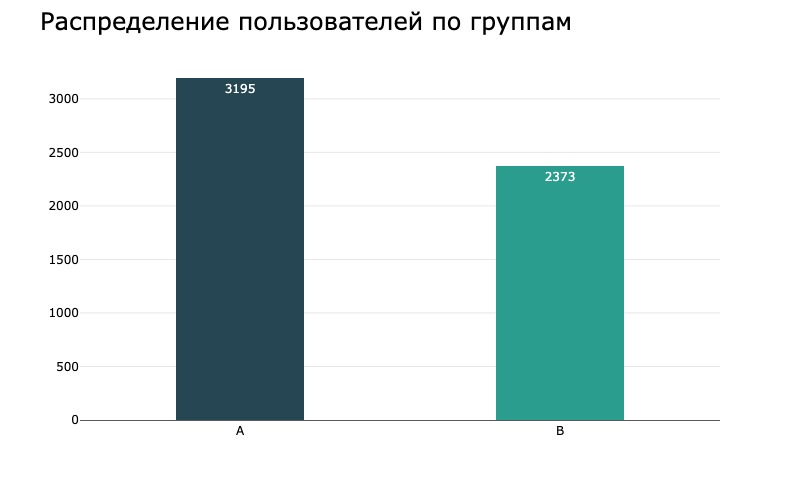

In [40]:
# создаем фигуру
fig = px.histogram(
    data_frame=rst_users,
    x='group',
    color='group',
    color_discrete_sequence=colors,
    width=800,
    text_auto=True
)

# наводим красоту и добавляем заголовок
style_plot(
    fig,
    title='Распределение пользователей по группам'
)

# убираем легенду и делаем отступы между столбцами
fig.update_layout(
    bargap=0.6,
    showlegend=False,
    
)

fig.show()

В группе А (контрольной) около 3200 пользователей, а в группе Б (эксперементальной) их около 2400. То есть разница примерно в 800 пользователей.

### Распределение пользователей по дате привлечения

Посмотрим в какие дни были привлечены пользователи:

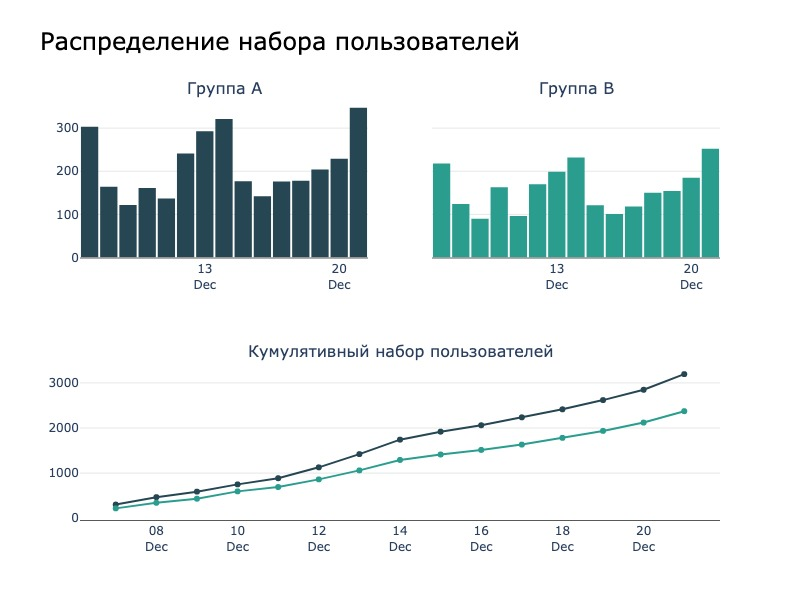

In [41]:
# готовим данные для визуализации кумулятивного набора пользователей
to_plot = rst_users.pivot_table(
    index='first_date',
    columns='group',
    values='user_id',
    aggfunc='count'
).cumsum(axis=0).reset_index()

# создаем фигуру 
fig = make_subplots(
    cols=2,
    rows=2,
    shared_yaxes=True,
    subplot_titles=['Группа A', 'Группа B', 'Кумулятивный набор пользователей'],
    specs=[
        [{}, {}],
        [{"colspan": 2}, None]],
)

for i, group in enumerate(['A', 'B']):
    # добавляем гистограмму набора пользователей по датам
    fig.add_trace(
        go.Histogram(
            x=rst_users.query('group == @group')['first_date'],
            marker={'color': colors[i]},
            name='Group ' + group
        ),
        row=1, col=i+1
    )

    # добавляем кумулятивный график набора пользователей
    fig.add_trace(
        go.Scatter(
            x=to_plot['first_date'],
            y=to_plot[group],
            marker={'color': colors[i]},
            name='Group ' + group
        ), row=2, col=1,
    )

# настроим высоту фигуры
fig.update_layout(height=600)

# настроим формат подписей к оси Х
fig.update_xaxes(tickformat = '%d<br>%b')

# стилизуем график
style_subplots(fig, title= 'Распределение набора пользователей',)

fig.show()

Графики набора пользователей очень похожи, за исключением того, что в группу А попадало несколько больше пользователей. Кумулятивная линия также без рывков и плавно идет наверх.

### Распределение пользователей по девайсам

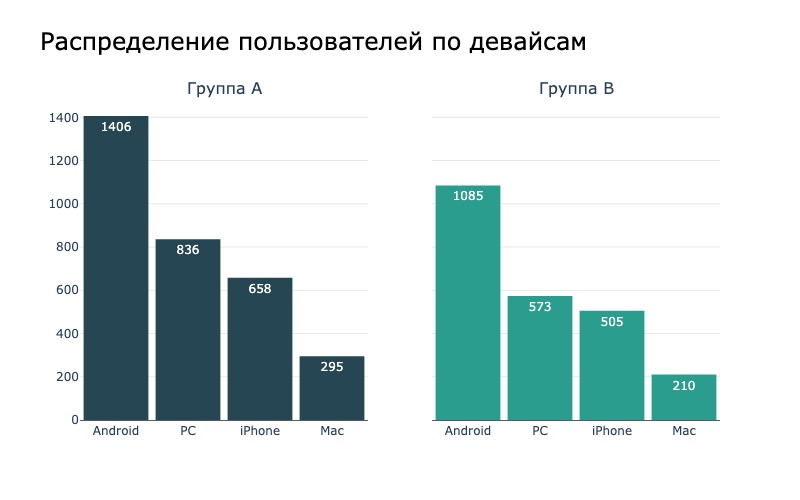

In [42]:
# создаем фигуру
fig = make_subplots(
    rows=1,
    cols=2,
    shared_yaxes=True,
    subplot_titles=['Группа А', 'Группа B']
)

# добавляем гистограммы по группам 
for i, group in enumerate(['A', 'B']):
    fig.add_trace(
        go.Histogram(
            x=rst_users.query('group == @group')['device'],
            text=rst_users.query('group == @group').groupby('device')['user_id'].count().sort_values(ascending=False),
            name='group ' + group,
            marker_color=colors[i],
        ), row=1, col=i+1
    )

# наводим красоту
style_subplots(fig, title='Распределение пользователей по девайсам')

# сортируем столбцы по возрастанию
fig.update_xaxes(
    categoryorder='total descending'
)

fig.show()

Как мы уже говорили, группы распределены по девайсам равномерно. Большинство пользователей используют Android, меньшинство – Mac.

### Доли покупателей по группам

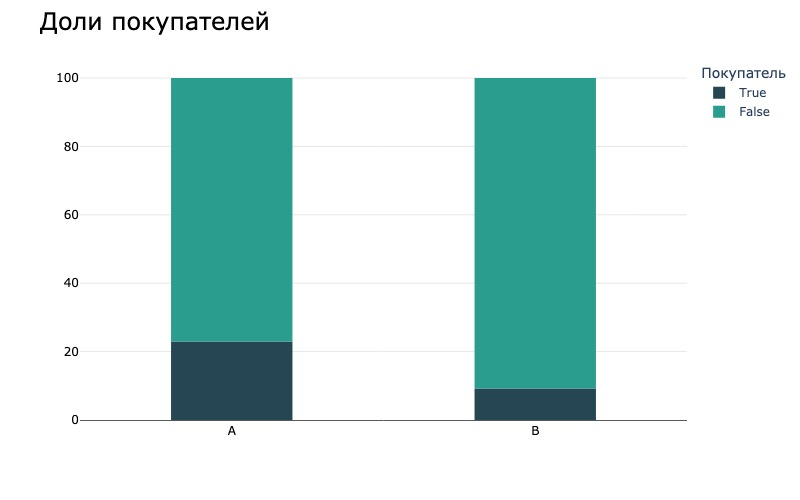

In [43]:
# создаем фигуру
fig = px.histogram(
    data_frame=rst_users,
    x='group',
    color='is_buyer',
    width=800,
    color_discrete_sequence=colors,
    barnorm='percent'
)

# наводим красоту
style_plot(fig, title='Доли покупателей')



# задаем отступы между столбцами 
fig.update_layout(
    bargap=0.6,
    legend_title='Покупатель',
    xaxis_categoryorder='array'
)

# выводим фигуру
fig.show()

В группе А 23% пользователей являются клиентами, а вот в группе В такими являются лишь 9%. Различия выглядят впечатляюще.

### Распределение выручки от клиентов

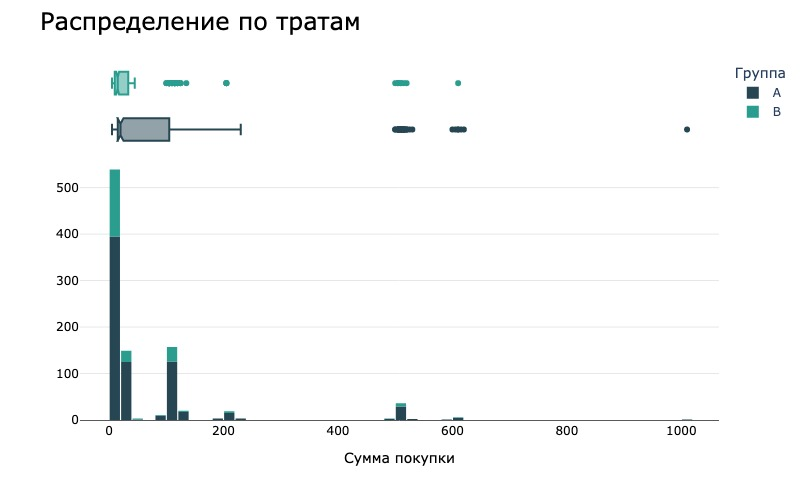

In [44]:
# создаем фигуру
fig = px.histogram(
    data_frame=rst_users.query('is_buyer == True'),
    x='total',
    color='group',
    color_discrete_sequence=colors,
    width=800,
    marginal='box' # добавляем ящик с усами над гистограммой
)

# наводим красоту
style_plot(
    fig,
    title='Распределение по тратам',
    xlabel='Сумма покупки'
    )

# добавим заголовок к легенде и отступы между столбцами 
fig.update_layout(
    bargap=0.1,
    legend_title='Группа',
)

fig.show()

Диапазон сумм покупки в группе А шире и в среднем больше: медианная сумма покупки в группе А около 20, а в группе В около 15. В данных присутствуют выбросы, например в группе А есть клиент, который закупился более чем на 1000. Вообще бОльшая часть распределения лежит до 40, также есть группа пользователей с показателями от 80 до 140

## Исследование событий

Перед тем как изучать события подготовим данные. Выделим только события пользователей, которые участвуют в тесте:

In [45]:
# создаем таблицу с событями пользователей, которые участвовали в тесте 
rst_events = events[events['user_id'].isin(rst_users['user_id'])].copy()

# приводим даты к нужному формату и типу
rst_events['event_dt'] = pd.to_datetime(rst_events['event_dt'].apply(lambda x: x.strftime('%Y-%m-%d')))

# сортируем события по дате обнуляем индексы
rst_events = rst_events.sort_values(by='event_dt').reset_index(drop=True)

# добавим для пользователей их группы в АБ тестировании
rst_events = rst_events.merge(rst_users[['user_id', 'group']], on='user_id', how='left')

# выводим первые 5 строчек 
rst_events.head()

,user_id,event_dt,event_name,group
0,894A2506B3A50D03,2020-12-07,product_page,B
1,5E0FE312B9349ADB,2020-12-07,login,B
2,5E0FE312B9349ADB,2020-12-07,purchase,B
3,F057A0C8EFECDBEE,2020-12-07,login,B
4,F057A0C8EFECDBEE,2020-12-07,product_cart,B


Теперь данные готовы к анализу.

### Распределение событий на пользователя

Посмотрим сколько событий совершает пользователь. Будем смотреть на относительные показатели для каждой группы:

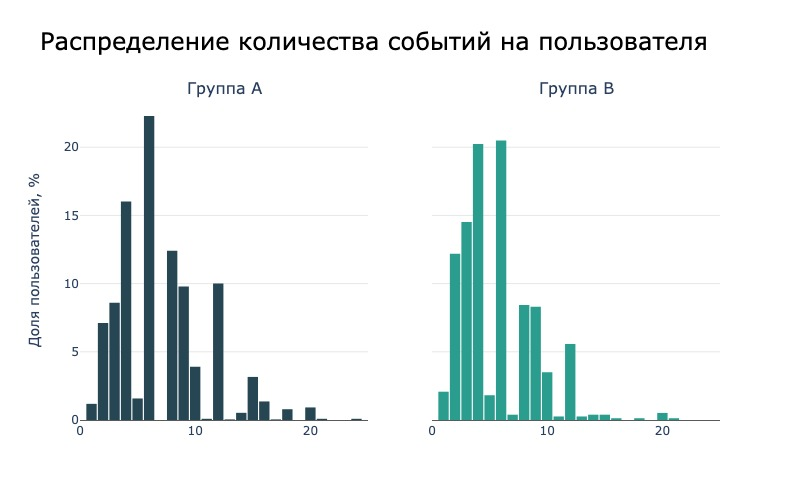

In [46]:
# готовим данные к визуализации
to_plot = rst_events.groupby(['user_id', 'group']).agg({'event_name': 'count'}).reset_index()

# создаем фигуру
fig = make_subplots(
    rows=1,
    cols=2,
    shared_yaxes=True,
    subplot_titles=['Группа А', 'Группа B']
)

# добавляем гистограммы по группам 
for i, group in enumerate(['A', 'B']):
    fig.add_trace(
        go.Histogram(
            x=to_plot.query('group == @group')['event_name'],
            name='group ' + group,
            marker_color=colors[i],
            histnorm='percent'
        ), row=1, col=i+1
    )

# наводим красоту
style_subplots(
    fig, 
    title='Распределение количества событий на пользователя'
)

# задаем диапазон значений для оси Х
fig.update_xaxes(
    range=[0,25]
)

# задаем заголовок для оси Y
fig.update_layout(
    yaxis_title_text='Доля пользователей, %'
)


fig.show()

Для бОльшей доли пользователей обеих групп характерно совершать 4 или 6 событий. В группе А – 4 события совершают 16% пользователей, а 6 событий 22% пользователей. В группе Б – 4 и 6 событий совершают по 20% пользователей.

Еще заметна интересная деталь – очень мало пользователей совершают 5, 7 и 11 событий. 

### Распределение количества событий до первой покупки

Подготовим данные для визуализации:

In [47]:
# находим дату первой покупки для каждого пользователя
to_plot = rst_events.query('event_name == "purchase"').groupby('user_id').agg({'event_dt': 'first'}).reset_index()

# функция для подсчета событий до первой покупки
def count_events(row):
    result = (
        len(rst_events[
            (rst_events['event_name'] != 'purchase') &
            (rst_events['user_id'] == row['user_id']) &
            (rst_events['event_dt'] <= row['event_dt'])
        ])
        )
    return result

# добавим количество событий до первой покупки
to_plot['n_events'] = to_plot.apply(lambda x: count_events(x), axis=1)

# добавим группу для каждого покупателя
to_plot = to_plot.merge(rst_users[['user_id', 'group']], on='user_id', how='left')

У нас готова таблица с количеством событий до первой покупки пользователя. Смотрим распределения:

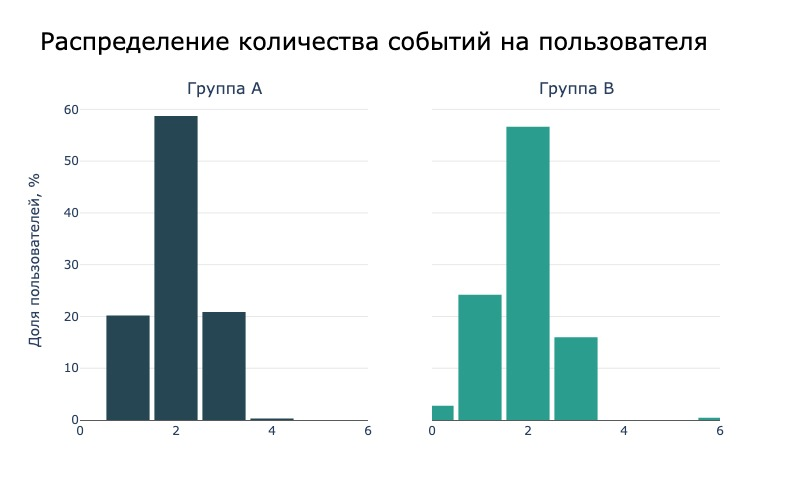

In [48]:
# создаем фигуру
fig = make_subplots(
    rows=1,
    cols=2,
    shared_yaxes=True,
    subplot_titles=['Группа А', 'Группа B']
)

# добавляем гистограммы по группам 
for i, group in enumerate(['A', 'B']):
    fig.add_trace(
        go.Histogram(
            x=to_plot.query('group == @group')['n_events'],
            name='group ' + group,
            marker_color=colors[i],
            histnorm='percent'
        ), row=1, col=i+1
    )

# наводим красоту
style_subplots(
    fig, 
    title='Распределение количества событий на пользователя'
)

# задаем диапазон значений для оси Х
fig.update_xaxes(
    range=[0,6]
)

# задаем заголовок для оси Y
fig.update_layout(
    yaxis_title_text='Доля пользователей, %',
)

fig.show()

Распределения оказались похожими: около 60% пользователей совершают 2 события перед покупкой. Также примерно по 20% пользователей совершают 1 или 3 действия. 

### Строим воронку

Перед тем как строить воронку, нам нужно подготовить данные. Для этого создадим таблицу с названиями событий и групп и количеством пользователей совершивших действие хотя бы 1 раз. 

In [49]:
# готовим данные
to_plot = (
    rst_events.pivot_table(
        index=['group', 'event_name'],
        values='user_id',
        aggfunc='nunique'
    )
    .reset_index()
    .rename(columns={
        'user_id': 'n_users'
    })
)

# добавим общее количество пользователей по группам
to_plot = pd.concat(
    [to_plot,
    pd.DataFrame({
        'group': ['A', 'B'],
        'event_name': ['all_users'] * 2,
        'n_users': [len(rst_users.query('group == @group')) for group in ['A', 'B']]
    })]
)

# сортируем данные по группам и количеству
to_plot = to_plot.sort_values(by=['group', 'n_users'], ascending=False).reset_index(drop=True)

Данные готовы, посмотрим на них попробуем сформировать воронку:

In [50]:
# выводим данные
to_plot

,group,event_name,n_users
0,B,all_users,2373
1,B,login,771
2,B,product_page,429
3,B,purchase,219
4,B,product_cart,214
5,A,all_users,3195
6,A,login,2279
7,A,product_page,1476
8,A,purchase,734
9,A,product_cart,686


Похоже, что воронка выглядит следующим образом: логин, продуктовая страница и покупка. Видимо товар можно купить прямо из карточки товара, так как событий `product_cart`, то есть просмотров корзины меньше чем покупок. Срежем данные о просмотрах корзины и построим воронку:

In [51]:
# срежем события просмотра корзины
to_plot = to_plot.query('event_name != "product_cart"')

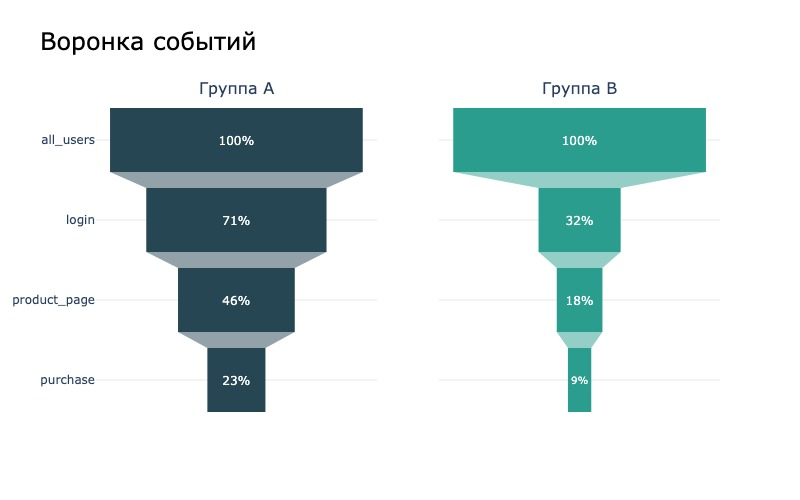

In [52]:
# создаем фигуру
fig = make_subplots(
    rows=1,
    cols=2,
    shared_yaxes=True,
    subplot_titles=['Группа А', 'Группа B']
)

# добавляем графики по группам
for i, group in enumerate(['A', 'B']):
    fig.add_trace(
        go.Funnel(
            y=to_plot.query('group == @group')['event_name'],
            x=to_plot.query('group == @group')['n_users'],
            name='group' + group, 
            marker_color=colors[i],
            textinfo = "percent initial"
        ),
        row=1,
        col=1+i
    )

# наводим красоту
style_subplots(
    fig,
    title='Воронка событий'
)

fig.show()

Самое узкое место в воронке для группы B – этап `login`. Лишь 32% процента перешли на этот этап в группе B. Для сравнения в группе А доля таких пользователей 71%. Но группа B немного сильнее в конверсии из `product_page` в `purchase`: у нее конверсия 51%, а в группе А 49%. Ну а различие общей конверсии в покупателя очень велико: в группе А – 23%, а в группе B – 9%.

### Распределение событий по дням

Чтобы корректно изучить распределение событий по дням мы визуализируем данные в 2-х разрезах:
1. Доля событий конкретного дня относительно количества всех событий по группе. То есть без привязки к количеству пользователей,
2. Количество событий на 1 пользователя в день по группам. То есть анализ с привязкой к количеству пользователей.

В первом случае мы изучим именно события и их распределение по дням, а во втором случае мы изучим динамику активности пользователей.

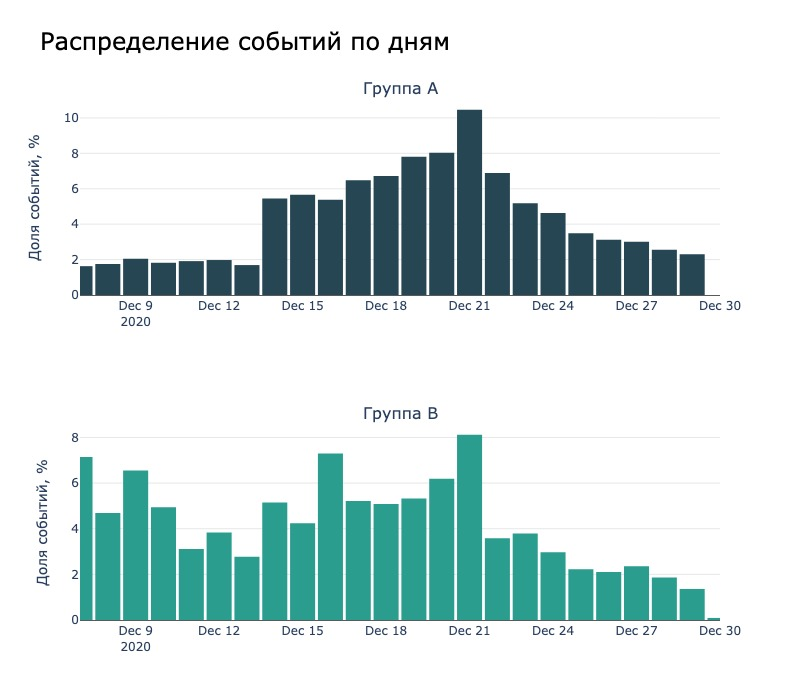

In [53]:
# создаем фигуру
fig = make_subplots(
    rows=2,
    cols=1,
    subplot_titles=['Группа А', 'Группа B'],
)

# добавляем графики по группам
for i, group in enumerate(['A', 'B']):
    fig.add_trace(
        go.Histogram(
            x=rst_events.query('group == @group')['event_dt'],
            name='Group '+ group, 
            histnorm='percent',
            marker_color=colors[i],
            # cumulative_enabled=True
        ),
        row=1+i,
        col=1
    )

# наводим красоту
style_subplots(
    fig,
    title='Распределение событий по дням'
)

# диапазон значений и заголовок для оси Y
fig.update_yaxes(
    # range=[0,12],
    title_text='Доля событий, %'
)

fig.update_layout(
    height=700
)


# диапазон значений для оси X
fig.update_xaxes(
    range=[rst_events['event_dt'].min(), rst_events['event_dt'].max()]
)

# выводим график 
fig.show()

Распределения немного отличаются. Прежде всего нужно помнить, что пользователей мы набирали до 21 декабря. В этой точке у обеих групп пик: больше пользователей, больше событий они совершают. 

В группе А рост количества событий совпадает с ростом количества пользователей. Но увеличение идет ступенчатое, с шагом примерно в неделю. То есть всю первую неделю, несмотря на кумулятивный рост количества пользователей количество событий оставалось неизменным. Затем с 14 декабря количество событий резко увеличилось. Это может быть связано с несколькими вариантами: либо ускорился набор пользователей, либо помимо свеженабранных начали активничать уже текущие пользователи. Если мы посмотрим на график распределения набора пользователей, то увидим, что в группе А 14 декабря был один из пиков по показателю привлечения новых пользователей. Затем следующий пик прироста новых пользователей был 21 декабря. В этот же день на графике виден пик и по количеству событий. Затем набор пользователей прекратился и количество событий стало медленно, но постепенно снижаться.

В группе Б также видна зависимость прироста новых пользователей и количества событий. за исключением того, что и набор пользователей, и количество событий по графику более "рваные", чем в группе А. 

Терперь посмотрим на показатель количества событий на пользователя по дням.

Подготовим данные:

In [54]:
# создаем таблицу с количеством уникальных пользователей и количеством событий в день
rst_events_agg = (
    rst_events.pivot_table(
        index= ['event_dt','group'],
        aggfunc={
            'user_id': 'nunique', # считаем уникальных пользователей 
            'event_name': 'count' # считаем количество событий в определеннную дату в определенной группе
        }
    )
    .reset_index()
    .rename(columns={
        'event_name': 'events_per_dt',
        'user_id': 'users_per_dt'
    })
    .sort_values(by=['group', 'event_dt'])
    .reset_index(drop=True)
)

# добавляем графу количество событий на пользователя в день
rst_events_agg['events_per_user'] = rst_events_agg['events_per_dt'] / rst_events_agg['users_per_dt']

Данные готовы, теперь можно их визуализировать:

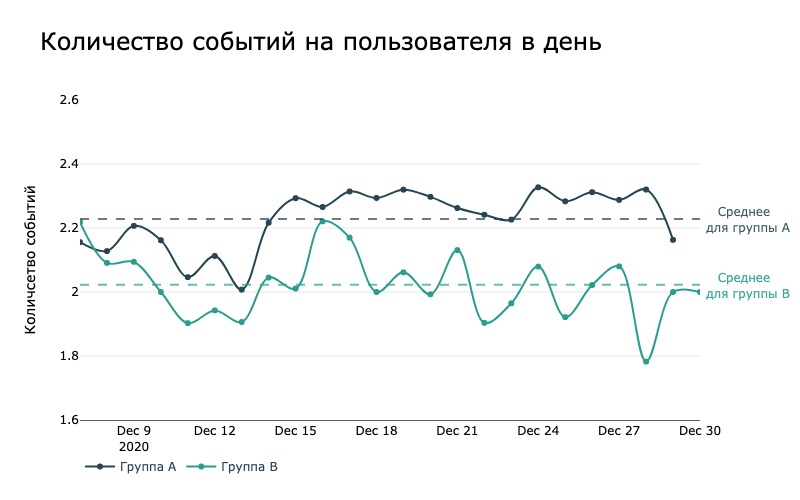

In [55]:
# создаем фигуру
fig = go.Figure()

# добавляем графики по группам
for i, group in enumerate(['A', 'B']):
    fig.add_trace(
        go.Scatter(
            x=rst_events_agg.query('group == @group')['event_dt'],
            y=rst_events_agg.query('group == @group')['events_per_user'],
            mode='lines+markers',
            name='Группа '+ group, 
            line_shape='spline', # сглаженная линия
            line_color=colors[i],
        )
    )

    # добавим линию со средним значением количества событий на пользователя по группам
    fig.add_hline(
        y=rst_events_agg.query('group == @group')['events_per_user'].mean(),
        line_dash="dash",
        line_color=opacity_colors(0.7)[i],
        annotation_text='Среднее <br> для группы ' + group,
        annotation_position='right',
        annotation_font_color=opacity_colors(0.9)[i]
    )

# ситилизуем график
style_plot(fig, title='Количество событий на пользователя в день')

# устанавливаем ширину графика
fig.update_layout(
    width=800,
    legend_orientation='h',
    margin_r=100
)

# диапазон подписей и заголовок для оси Y
fig.update_yaxes(
    range=[1.6, 2.6],
    title_text='Количсетво событий'
)

# настраимваем диапазон подписей к оси Х
fig.update_xaxes(
    range=[rst_events['event_dt'].min(), rst_events['event_dt'].max()]
)

# выводим график
fig.show()

В среднем пользователи группы В совершают немного меньше событий в день, чем пользователи из группы А.

Пользователи в группе А, которые пришли на первой неделе были менее активные, чем последующие. Но после 14 декабря показатель событий на пользователя в день немного подрос и оставался относительно стабильным до конца исследования.

В группе В самые активные пользователи были 7 и 14 декабря. Но в целом дисперсия по пользователям группы В выше, чем по пользователям группы А. До конца исследования показатель событий на пользователя так и не вышел на относительное плато, становясь то выше, то ниже.

## Выводы

Мы завершили исследовательский анализ данных и теперь имеем представление о пользователях разных групп теста. Сформулируем основные характерные черты для пользователей:
* Группа А больше группы В примерно на 800 пользователей. В группе А их 3195, а в группе В их 2373.
* Наполнялись пользователями группы также параллельно и в целом равномерно. Больше всего пользователей пришло 7, 14 и 21 декабря,
* Лидер среди платформ – Android, следом идут PC, iPhone и Mac соответственно,
* Конверсия в покупателя по группам довольно таки сильно отличается: в группе А покупателей 23% пользователей, а в группе B их всего лишь 9%,
* По тратам можно выделить 3 группы в порядке убывания количества пользователей:
    * Пользователи, которые тратят до 40$,
    * Пользователи, которые тратят до 140$,
    * Пользователи, которые тратят свыше 140$
* В группе А шире диапазон трат пользователей, чем в группе В. Медианное значение суммы покупок пользователей группы А – 20$, а группы В – 15$
* Большинство пользователей обеих групп совершают по 4 или 6 события. Еще заметна интересная деталь, что очень мало пользователей совершают по 5, 7 и 11 событий.
* Перед первой покупкой в обеих группах пользователи совершают 2 события. Судя по всему, покупку можно сделать не заходя в корзину, а сразу со страницы продукта.
* Воронки по группам отличаются довольно таки сильно. В группе В самое узкое место это первый этап `login`. Конверсия в это действие у пользователей группы В – 32%. Для сравнения в группе А конверсия в `login` – 72%. Пользователи группы В лучше конвертируются лишь из `product_page` в `purchase` – 51% против 49% в группе А.
* В среднем пользователи из группы А совершают больше событий в день, чем пользователи группы В.

# Оценка результатов А/В-тестирования

Данные предобработаны и изучены. Теперь можно приступать к основной задаче исследования – оценке результатов А/В-тестирования.

Напомним, какой эффект мы ожидаем увидеть от А/В-тестирования:

За 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%:
- конверсии в просмотр карточек товаров — событие `product_page`,
- просмотры корзины — `product_cart`,
- покупки — `purchase`.

Найдем текущие метрики конверсии по этим показателям:

In [56]:
# готовим таблицу с конверсией в действие на 14-й день
conversions = rst_users[['user_id', 'first_date']].copy()

# сортируем пользователей по дате первого события 
conversions = conversions.sort_values(by='first_date').reset_index(drop=True)

# добавляем дату 14-го дня в продукте, чтобы по ней измерять конверсию
conversions['last_date'] = conversions['first_date'].apply(
    lambda x: x + dt.timedelta(days=14)
)

In [57]:
# функция определяет конвертировался ли пользователь в действие
# row – строка датасета
# action – действие, конверсию в которое проверяем
def is_cr(row, action):
    result = action in rst_events[
        (rst_events['user_id'] == row['user_id']) &
        (rst_events['event_dt'] < row['last_date'])
    ]['event_name'].unique()
    return result

In [58]:
# добавляем столбцы с информацией о конверсии по шагам
for event in tqdm(['purchase', 'product_page', 'product_cart']):
    conversions['cr_' + event] = conversions.apply(lambda x: is_cr(x, event), axis=1)

100%|██████████| 3/3 [00:24<00:00,  8.01s/it]


In [59]:
# добавим группу к каждому пользователю
conversions = conversions.merge(rst_users[['user_id', 'group']], on='user_id', how='left')

# оставляем только нужные нам столбцы в логичном порядке
conversions = conversions[['user_id', 'group', 'cr_product_page', 'cr_product_cart', 'cr_purchase']]

# выведем первые 5 строк получившейся таблицы
conversions.head()

,user_id,group,cr_product_page,cr_product_cart,cr_purchase
0,D1ABA3E2887B6A73,A,True,True,True
1,1632E8454F655D06,B,False,False,False
2,A27903E52DAF4FB5,A,False,False,False
3,94DEE458C4F03B12,B,True,False,False
4,6CF06DC9CCEEADE3,B,False,False,False


In [60]:
# создадим таблицу сгруппированную по тестовой группе
conversions_grouped = conversions.groupby('group').mean().T

# добавим столбец с целью по конверсии
conversions_grouped['target'] = conversions_grouped['A'] * 1.1

У нас готова таблица с показателями текущей конверсии и целью по конверсии. Выведем ее:

In [61]:
# выводим таблицу с показателями текущей конверсии
conversions_grouped

group,A,B,target
cr_product_page,0.461972,0.180784,0.508169
cr_product_cart,0.214710,0.090181,0.236182
cr_purchase,0.229734,0.092288,0.252707


Сразу хочется сделать вывод о том, что группа В не оправдала надежд. Показатели конверсии в этой группе крайне низки и далеки от цели. Но не будем делать поспешных выводов и проверим все гипотезы статистически.

### Статистическая проверка гипотез

Нам нужно проверить 3 гипотезы: про конверсию в просмотр карточки, в просмотр корзины и в покупку.

Для проверки будем использовать Z-критерий для долей. Для начала определим уровень значимости альфа – 0.05. Но так как мы будем проверять сразу 3 гипотезы на одних и тех же данных, то вероятность ошибиться в какой либо из проверок возрастает. Чтобы исправить это применим поправку Бонферрони: разделим уровень значимости на количество статистических проверок, то есть на 3.

Вычислим итоговый уровень значимости:

In [62]:
# определяем уровень значимости с поправкой Бонферрони
alpha = 0.05 / 3 

Чтобы тест сработал корректно, убедимся, что у нас достаточно пользователей. Для этого нам нужно задать еще 2 параметра: уровень мощности и соотношение выборок.

Уровень мощности возьмем стандартный – 0.08. А соотношение выборок посчитаем:

In [63]:
# соотношение выборок
samples_ratio = len(rst_users.query('group == "B"')) / len(rst_users.query('group == "A"'))

Теперь нам известны все параметры и мы можем определить рекомендованный размер выборки. Делать мы это будем при помощи двух функций из модуля statsmodels:
* `proportion_effectsize()` – определит стандартизированный размер эффекта. 
* `NormalIndPower().solve_power()` – определит рекомендуемый размер выборки.

Запустим цикл, который посчитает размер бОльшей выборки для каждого показателя:

In [64]:
# список в которому будем хранить размеры выборок для каждого показателя
sample_sizes = []

# ищем размер выборки для каждого теста 
for i in range(len(conversions_grouped)):

    # найдем стандартизированный размер выборки
    es = sms.proportion_effectsize(conversions_grouped.iloc[i]['A'], conversions_grouped.iloc[i]['target'])

    # находим размер бОльшей выборки
    sample_size = round(sms.NormalIndPower().solve_power(
        effect_size = es,    # стандартизированный размер эффекта
        power=0.8,           # уровень мощности   
        alpha=alpha,         # уровень значимости
        ratio=samples_ratio  # соотношение выборок
        ))

    sample_sizes.append(sample_size)

# добавляем столбец с рекомендованным размером бОльшей выборки
conversions_grouped['bigger_sample_size'] = sample_sizes

Мы определили рекомендуемые размеры выборки для каждого теста. Теперь посмотрим соблюдается ли это условия с нашими данными:

In [65]:
# проверим соблюдаются ли рекомендации по размеру для бОльшей выборки
conversions_grouped['bigger_sample_size'] < len(rst_users.query('group == "A"'))

cr_product_page     True
cr_product_cart    False
cr_purchase        False
Name: bigger_sample_size, dtype: bool

In [66]:
# проверим соблюдаются ли рекомендации по размеру для меньшей выборки
conversions_grouped['bigger_sample_size'] * samples_ratio < len(rst_users.query('group == "A"'))

cr_product_page     True
cr_product_cart    False
cr_purchase        False
Name: bigger_sample_size, dtype: bool

Условие по размеру выборки соблюдается лишь для показателя `cr_product_page`. По остальным показателям нам недостаточно данных, чтобы корректно сделать тест. В связи с этим, мы не будем делать статистическую проверку гипотез для других показателей иначе мы получим просто некорректные результаты, которым сложно будет доверять.

А так как мы будем проводить 1 тест, а не 3, то и уровень значимости мы можем вернуть к исходному показателю – 0.05.

In [67]:
# возвращаем исходный уровень значимости
alpha = 0.05

Сформулируем гипотезы:
- Нулевая гипотеза: конверсии в просмотр карточки продукта в контрольной и тестовой группе статистически не отличаются,
- Альтернативная гипотеща: конверсии в просмотр карточки продукта в контрольной и тестовой группе статистически отличаются.

Проверяем:

In [68]:
# запускаем тест и находим значение 
_, pval = proportions_ztest(
    [conversions.query('group == "A"')['cr_product_page'].sum(), conversions.query('group == "B"')['cr_product_page'].sum()],
    [len(conversions.query('group == "A"')['cr_product_page']), len(conversions.query('group == "B"')['cr_product_page'])]
)

if pval < alpha:
    print('Есть основания отклонить нулевую гипотезу: конверсии по группам отличаются.')
else:
    print('у нас недостаточно оснований отклонить нулевую гипотезу: конверсии по группам не отличаются.')

Есть основания отклонить нулевую гипотезу: конверсии по группам отличаются.


Тест показал, что конверсии в выборках статистически значимо отличаются друг от друга. А до этого мы видели, что конверсия в эксперементальной группе гораздо ниже, чем конверсия в контрольной. Теперь мы можем сказать, что это не случайность, а действительно с новой системой рекомендаций конверсия в просмотр страницы продукта меньше.

## Выводы

* Все показатели конверсии в группе В ниже, чем в группе А
* При уровне значимости равном 0.017 (0.05 с поправкой Бонферрони), мощности теста 0.8 и соотношении размеров выборок 0.75 (меньшая относительно бОльшей) по размеру выборки проходит только показатель конверсии в просмотр карточки продукта. Чтобы проводить тест остальных показателей нам требуется увеличить количество пользователей, либо ухудшить какой-либо параметр теста.
* Двусторонний z-тест показал, что конверсии в просмотр карточки продукта статистически отличаются между группами. То есть группа Б показывает себя хуже и это статистически значимо.

# Общие выводы

На основе исследовательского анализа данных и оценки АБ-теста сделаем итоговые выводы.

### Исследовательский анализ данных

Мы проверили данные на соответствие пунктам ТЗ и сделали следующие выводы:
* Соответствует ТЗ:
    * Дата запуска 07.12.2020,
    * Крайняя дата набора пользователей 21.12.2020,
    * Количество участников теста – 5918 человек (по ТЗ планировалось 6000),
    * Аудитория теста – 5568 пользователей из Европы (по ТЗ планировалось 5654),
* Не соответствует ТЗ:
    * Дата последнего события в тесте – 30.12.2020 (по ТЗ планировалось 04.01.2021),
    * Лайфтайм пользователей – 7 дней (по ТЗ предполагалось, что лайфтайм будет 14 дней)

Во время проведения теста проходили 2 маркетинговые активности и одна из них проходила в нашем целевом регионе (EU). Так как она проводилась после того как мы перестали набирать участников теста, и влияла на обе группы одинаково, то мы решили оставить все как есть.

Дальше мы изучили аудиторию теста и удалили пользователей не из региона EU. В итоге у нас осталось 5568 пользователей. 

При исследовательском анализе данных самые сильные отличия мы увидели в воронке. В группе В самое узкое место это первый этап `login`. Конверсия в это действие у пользователей группы В – 32%. Для сравнения в группе А конверсия в `login` – 72%. Пользователи группы В лучше конвертируются лишь из `product_page` в `purchase` – 51% против 49% в группе А.

Низкая конверсия в `login` вызывает подозрения. Нужно узнать нет ли какого-нибудь бага в эксперементальной версии продукта.

### Статистическая проверка гипотез

К оценке АБ-тестирования мы уже подходили с пониманием, что данные не по всем пунктам соответствуют ТЗ и исследование проводилось в предверии новогодних праздников, что могло повлиять на поведение пользователей. Последним этапом оценки корректности данных для статистического теста была проверка размера выборок.

Тестировать мы решили с помощью z-теста для пропорций со следующими параметрами:
* Уровень значимости альфа – 0.05 с поправкой Бонферрони на множественные тесты (на 3),
* Мощность теста – 0.8,
* Отношение меньшей выборки к бОльшей – 0.74

На основе этих параметров мы сделали проверку размера выборок. И по этому критерию прошло только тестирование конверсии в просмотр карточки продукта. Для всех остальных конверсий данных оказалось недостаточно.

Статистический тест показал, что выборки принадлежат разным генеральным совокупностям. То есть результаты значимо отличаются друг от друга. Соответственно более низкая конверсия в эксперементальной группе это не случайность.

### Заключение

Можно сделать заключение о том, что тест был проведен некорректно. Во-первых, данные не соответствуют большинству пунктов ТЗ. Во-вторых, для проведения некоторых статистических тестов недостаточны размеры выборок.

Возможно, что проблема недостаточного размера выборок в том, что не все данные дошли, так как последнее действие пользователей, которые участвовали в тесте было 30 декабря, а тест рассчитан до 4 января. Если же проблема не в это, то следует увеличить размеры выборок и добрать пользователей.